In [1]:
import os
import shutil
import numpy as np
from PIL import Image, ImageStat
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

Data Cleaning

In [2]:
DATASET_DIR = os.path.join(os.path.expanduser("~"), "Documents", "animals")
TARGET_SIZE = (224, 224)

BAD_IMG_DIR = os.path.join(os.path.expanduser("~"), "Documents", "bad_animal_images")
os.makedirs(BAD_IMG_DIR, exist_ok=True)

# Function to get all image file paths recursively
def get_all_image_files(root_dir):
    image_files = []
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_files.append(os.path.join(subdir, file))
    return image_files

image_files = get_all_image_files(DATASET_DIR)
print(f"Total images found recursively: {len(image_files)}")
print("First few images:", image_files[:5])

# Check for corrupted images, moving them to bad_images
def check_and_move_corrupted_images(image_paths):
    corrupted = []
    for file_path in image_paths:
        try:
            with Image.open(file_path) as img:
                img.verify()
        except Exception:
            corrupted.append(file_path)
            # Move to bad_images folder; preserve folder structure or rename to avoid collisions
            dest_path = os.path.join(BAD_IMG_DIR, os.path.basename(file_path))
            shutil.move(file_path, dest_path)
            print(f"Moved corrupted image: {file_path}")
    print(f"Total corrupted images moved: {len(corrupted)}")
    return corrupted

corrupted_images = check_and_move_corrupted_images(image_files)

# After removing corrupted images, update image list again
image_files = [f for f in image_files if f not in corrupted_images]

# Low quality detection
def is_low_quality(image, brightness_thresh=20, contrast_thresh=15):
    stat = ImageStat.Stat(image.convert('L'))
    brightness = stat.mean[0]
    contrast = stat.stddev[0]
    return brightness < brightness_thresh or contrast < contrast_thresh

def move_low_quality_images(image_paths):
    low_quality = []
    for file_path in image_paths:
        try:
            with Image.open(file_path) as img:
                if is_low_quality(img):
                    low_quality.append(file_path)
                    dest_path = os.path.join(BAD_IMG_DIR, os.path.basename(file_path))
                    shutil.move(file_path, dest_path)
                    print(f"Moved low-quality image: {file_path}")
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    print(f"Total low-quality images moved: {len(low_quality)}")
    return low_quality

low_quality_images = move_low_quality_images(image_files)

# Update image list after moving low-quality images
image_files = [f for f in image_files if f not in low_quality_images]

# Resize images
def resize_images(image_paths, target_size=TARGET_SIZE):
    resized_count = 0
    for file_path in image_paths:
        try:
            with Image.open(file_path) as img:
                if img.size != target_size:
                    img = img.resize(target_size)
                    img.save(file_path)
                    resized_count += 1
                    print(f"Resized image: {file_path}")
        except Exception as e:
            print(f"Error resizing {file_path}: {e}")
    print(f"Total images resized: {resized_count}")

resize_images(image_files)

# Label folder check (for immediate subfolders only)
def check_label_folders(base_folder):
    for label in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label)
        if os.path.isdir(label_path):
            images = get_all_image_files(label_path)
            if len(images) == 0:
                print(f"Warning: Label folder '{label}' contains no images.")
        else:
            # Handle files directly inside base folder if any
            pass

check_label_folders(DATASET_DIR)

Total images found recursively: 5400
First few images: ['C:\\Users\\adren\\Documents\\animals\\antelope\\02f4b3be2d.jpg', 'C:\\Users\\adren\\Documents\\animals\\antelope\\03d7fc0888.jpg', 'C:\\Users\\adren\\Documents\\animals\\antelope\\058fa9a60f.jpg', 'C:\\Users\\adren\\Documents\\animals\\antelope\\0a37838e99.jpg', 'C:\\Users\\adren\\Documents\\animals\\antelope\\0b1a3af197.jpg']
Total corrupted images moved: 0
Moved low-quality image: C:\Users\adren\Documents\animals\bat\0315a4b6b7.jpg
Moved low-quality image: C:\Users\adren\Documents\animals\bat\3d1dda7723.jpg
Moved low-quality image: C:\Users\adren\Documents\animals\bat\4c23df5b08.jpg
Moved low-quality image: C:\Users\adren\Documents\animals\bat\557b9d9df6.jpg
Moved low-quality image: C:\Users\adren\Documents\animals\bat\68b39cc449.jpg
Moved low-quality image: C:\Users\adren\Documents\animals\bat\74d55d6d41.jpg
Moved low-quality image: C:\Users\adren\Documents\animals\bat\82a9875c4a.jpg
Moved low-quality image: C:\Users\adren\Doc

Data Segmentation

In [3]:
DATASET_DIR = os.path.join(os.path.expanduser("~"), "Documents", "animals")
K_FOLDS = 5
TEST_RATIO = 0.15  # Hold out 15% for final test set

# Gather all image paths and labels
image_paths = []
labels = []

for label in sorted(os.listdir(DATASET_DIR)):
    label_folder = os.path.join(DATASET_DIR, label)
    if os.path.isdir(label_folder):
        for fname in os.listdir(label_folder):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_paths.append(os.path.join(label_folder, fname))
                labels.append(label)

image_paths = np.array(image_paths)
labels = np.array(labels)

print(f"Total images: {len(image_paths)}, Total classes: {len(set(labels))}")

# Hold out a stratified test set
sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=42)
train_val_idx, test_idx = next(sss.split(image_paths, labels))

train_val_images = image_paths[train_val_idx]
train_val_labels = labels[train_val_idx]
test_images = image_paths[test_idx]
test_labels = labels[test_idx]

print(f"Held-out test set: {len(test_images)} images")
print(f"Test set class distribution: {dict(zip(*np.unique(test_labels, return_counts=True)))}")

# Perform K-Fold on remaining training+validation set
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_images, train_val_labels), 1):
    train_images, val_images = train_val_images[train_idx], train_val_images[val_idx]
    train_labels, val_labels = train_val_labels[train_idx], train_val_labels[val_idx]

    print(f"\nFold {fold}")
    print(f"  Train size: {len(train_images)}, Validation size: {len(val_images)}")
    print(f"  Train class distribution: {dict(zip(*np.unique(train_labels, return_counts=True)))}")
    print(f"  Val class distribution: {dict(zip(*np.unique(val_labels, return_counts=True)))}")

Total images: 5359, Total classes: 90
Held-out test set: 804 images
Test set class distribution: {np.str_('antelope'): np.int64(9), np.str_('badger'): np.int64(9), np.str_('bat'): np.int64(7), np.str_('bear'): np.int64(9), np.str_('bee'): np.int64(9), np.str_('beetle'): np.int64(9), np.str_('bison'): np.int64(9), np.str_('boar'): np.int64(9), np.str_('butterfly'): np.int64(9), np.str_('cat'): np.int64(9), np.str_('caterpillar'): np.int64(9), np.str_('chimpanzee'): np.int64(9), np.str_('cockroach'): np.int64(9), np.str_('cow'): np.int64(9), np.str_('coyote'): np.int64(9), np.str_('crab'): np.int64(9), np.str_('crow'): np.int64(9), np.str_('deer'): np.int64(9), np.str_('dog'): np.int64(9), np.str_('dolphin'): np.int64(9), np.str_('donkey'): np.int64(9), np.str_('dragonfly'): np.int64(9), np.str_('duck'): np.int64(9), np.str_('eagle'): np.int64(9), np.str_('elephant'): np.int64(9), np.str_('flamingo'): np.int64(9), np.str_('fly'): np.int64(9), np.str_('fox'): np.int64(9), np.str_('goat'):

Data Augmentation

In [4]:
# Augmentation pipeline for training
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),                  # Resize to slightly larger than 224x224
    transforms.RandomResizedCrop(224),              # Crop to 224x224 randomly
    transforms.RandomHorizontalFlip(),              # Random horizontal flip
    transforms.RandomRotation(15),                  # Slight rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color variation
    transforms.ToTensor(),                          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225]),
])

# Transformation pipeline for validation and test (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

Custom Dataset Class

In [5]:
class AnimalDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(set(labels)))}
        self.targets = [self.label_to_idx[label] for label in labels]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.targets[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
BATCH_SIZE = 32
NUM_WORKERS = 0

if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


Model Training

In [8]:
NUM_EPOCHS = 10
NUM_CLASSES = len(set(labels))

def train_one_fold(fold, train_images, train_labels, val_images, val_labels):
    # Datasets
    train_dataset = AnimalDataset(train_images, train_labels, transform=train_transform)
    val_dataset = AnimalDataset(val_images, val_labels, transform=val_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    # Model
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    model = model.to(device)

    # Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Metric storage
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # For confusion matrix
    all_val_preds = []
    all_val_targets = []

    # Training Loop
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"[Fold {fold}] Epoch {epoch+1}/{NUM_EPOCHS} - Training"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_losses.append(running_loss)
        train_accuracies.append(train_accuracy)
        print(f"[Fold {fold}] Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"[Fold {fold}] Epoch {epoch+1} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                all_val_preds.extend(predicted.cpu().numpy())
                all_val_targets.extend(labels.cpu().numpy())

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        print(f"[Fold {fold}] Epoch {epoch+1}, Val Accuracy: {val_accuracy:.2f}%")

    # Save model weights
    torch.save(model.state_dict(), f"resnet50_fold{fold}.pth")
    print(f"✅ Saved model: resnet50_fold{fold}.pth")

    # Return collected metrics
    return {
        "model": model,
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "val_preds": all_val_preds,
        "val_targets": all_val_targets,
    }

# Store results per fold
fold_metrics = {}

# Train and save model for each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_images, train_val_labels), 1):
    train_images, val_images = train_val_images[train_idx], train_val_images[val_idx]
    train_labels, val_labels = train_val_labels[train_idx], train_val_labels[val_idx]

    print(f"\n========== Training Fold {fold} ==========")
    result = train_one_fold(fold, train_images, train_labels, val_images, val_labels)

    # Store everything for later use
    fold_metrics[fold] = {
        "train_losses": result["train_losses"],
        "train_accuracies": result["train_accuracies"],
        "val_accuracies": result["val_accuracies"],
        "val_preds": result["val_preds"],
        "val_targets": result["val_targets"],
    }


========== Training Fold 1 ==========
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\adren/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 39.4MB/s]
[Fold 1] Epoch 1/10 - Training: 100%|██████████| 114/114 [00:42<00:00,  2.71it/s]


[Fold 1] Epoch 1, Loss: 430.2297, Accuracy: 23.74%


[Fold 1] Epoch 1 - Validation: 100%|██████████| 29/29 [00:05<00:00,  5.36it/s]


[Fold 1] Epoch 1, Val Accuracy: 69.59%


[Fold 1] Epoch 2/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.62it/s]


[Fold 1] Epoch 2, Loss: 190.7431, Accuracy: 66.36%


[Fold 1] Epoch 2 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.98it/s]


[Fold 1] Epoch 2, Val Accuracy: 82.44%


[Fold 1] Epoch 3/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.60it/s]


[Fold 1] Epoch 3, Loss: 117.0047, Accuracy: 75.80%


[Fold 1] Epoch 3 - Validation: 100%|██████████| 29/29 [00:01<00:00, 16.03it/s]


[Fold 1] Epoch 3, Val Accuracy: 88.36%


[Fold 1] Epoch 4/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.65it/s]


[Fold 1] Epoch 4, Loss: 87.6733, Accuracy: 82.16%


[Fold 1] Epoch 4 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.98it/s]


[Fold 1] Epoch 4, Val Accuracy: 89.13%


[Fold 1] Epoch 5/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.63it/s]


[Fold 1] Epoch 5, Loss: 71.3302, Accuracy: 84.99%


[Fold 1] Epoch 5 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.83it/s]


[Fold 1] Epoch 5, Val Accuracy: 89.02%


[Fold 1] Epoch 6/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.63it/s]


[Fold 1] Epoch 6, Loss: 64.1414, Accuracy: 86.50%


[Fold 1] Epoch 6 - Validation: 100%|██████████| 29/29 [00:01<00:00, 16.07it/s]


[Fold 1] Epoch 6, Val Accuracy: 89.90%


[Fold 1] Epoch 7/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.61it/s]


[Fold 1] Epoch 7, Loss: 57.8996, Accuracy: 87.79%


[Fold 1] Epoch 7 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.75it/s]


[Fold 1] Epoch 7, Val Accuracy: 90.89%


[Fold 1] Epoch 8/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.60it/s]


[Fold 1] Epoch 8, Loss: 52.0388, Accuracy: 88.53%


[Fold 1] Epoch 8 - Validation: 100%|██████████| 29/29 [00:01<00:00, 16.13it/s]


[Fold 1] Epoch 8, Val Accuracy: 90.56%


[Fold 1] Epoch 9/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.62it/s]


[Fold 1] Epoch 9, Loss: 48.8807, Accuracy: 89.54%


[Fold 1] Epoch 9 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.98it/s]


[Fold 1] Epoch 9, Val Accuracy: 90.89%


[Fold 1] Epoch 10/10 - Training: 100%|██████████| 114/114 [00:25<00:00,  4.55it/s]


[Fold 1] Epoch 10, Loss: 49.6972, Accuracy: 89.38%


[Fold 1] Epoch 10 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.46it/s]


[Fold 1] Epoch 10, Val Accuracy: 90.23%
✅ Saved model: resnet50_fold1.pth

========== Training Fold 2 ==========


[Fold 2] Epoch 1/10 - Training: 100%|██████████| 114/114 [00:25<00:00,  4.50it/s]


[Fold 2] Epoch 1, Loss: 428.2913, Accuracy: 25.00%


[Fold 2] Epoch 1 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.99it/s]


[Fold 2] Epoch 1, Val Accuracy: 67.73%


[Fold 2] Epoch 2/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.64it/s]


[Fold 2] Epoch 2, Loss: 194.8078, Accuracy: 65.12%


[Fold 2] Epoch 2 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.95it/s]


[Fold 2] Epoch 2, Val Accuracy: 84.08%


[Fold 2] Epoch 3/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.66it/s]


[Fold 2] Epoch 3, Loss: 117.5996, Accuracy: 76.45%


[Fold 2] Epoch 3 - Validation: 100%|██████████| 29/29 [00:01<00:00, 16.15it/s]


[Fold 2] Epoch 3, Val Accuracy: 86.50%


[Fold 2] Epoch 4/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.64it/s]


[Fold 2] Epoch 4, Loss: 91.6922, Accuracy: 81.42%


[Fold 2] Epoch 4 - Validation: 100%|██████████| 29/29 [00:01<00:00, 16.13it/s]


[Fold 2] Epoch 4, Val Accuracy: 88.47%


[Fold 2] Epoch 5/10 - Training: 100%|██████████| 114/114 [00:26<00:00,  4.30it/s]


[Fold 2] Epoch 5, Loss: 73.0231, Accuracy: 84.77%


[Fold 2] Epoch 5 - Validation: 100%|██████████| 29/29 [00:01<00:00, 14.86it/s]


[Fold 2] Epoch 5, Val Accuracy: 89.68%


[Fold 2] Epoch 6/10 - Training: 100%|██████████| 114/114 [00:27<00:00,  4.12it/s]


[Fold 2] Epoch 6, Loss: 64.1598, Accuracy: 86.66%


[Fold 2] Epoch 6 - Validation: 100%|██████████| 29/29 [00:01<00:00, 14.86it/s]


[Fold 2] Epoch 6, Val Accuracy: 88.58%


[Fold 2] Epoch 7/10 - Training: 100%|██████████| 114/114 [00:27<00:00,  4.11it/s]


[Fold 2] Epoch 7, Loss: 56.8091, Accuracy: 87.71%


[Fold 2] Epoch 7 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.14it/s]


[Fold 2] Epoch 7, Val Accuracy: 90.01%


[Fold 2] Epoch 8/10 - Training: 100%|██████████| 114/114 [00:26<00:00,  4.25it/s]


[Fold 2] Epoch 8, Loss: 49.5445, Accuracy: 89.13%


[Fold 2] Epoch 8 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.27it/s]


[Fold 2] Epoch 8, Val Accuracy: 90.34%


[Fold 2] Epoch 9/10 - Training: 100%|██████████| 114/114 [00:26<00:00,  4.30it/s]


[Fold 2] Epoch 9, Loss: 49.1286, Accuracy: 89.87%


[Fold 2] Epoch 9 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.26it/s]


[Fold 2] Epoch 9, Val Accuracy: 89.13%


[Fold 2] Epoch 10/10 - Training: 100%|██████████| 114/114 [00:26<00:00,  4.29it/s]


[Fold 2] Epoch 10, Loss: 47.5910, Accuracy: 89.38%


[Fold 2] Epoch 10 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.22it/s]


[Fold 2] Epoch 10, Val Accuracy: 89.90%
✅ Saved model: resnet50_fold2.pth

========== Training Fold 3 ==========


[Fold 3] Epoch 1/10 - Training: 100%|██████████| 114/114 [00:26<00:00,  4.23it/s]


[Fold 3] Epoch 1, Loss: 433.1748, Accuracy: 24.29%


[Fold 3] Epoch 1 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.38it/s]


[Fold 3] Epoch 1, Val Accuracy: 69.26%


[Fold 3] Epoch 2/10 - Training: 100%|██████████| 114/114 [00:26<00:00,  4.33it/s]


[Fold 3] Epoch 2, Loss: 195.3660, Accuracy: 65.40%


[Fold 3] Epoch 2 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.46it/s]


[Fold 3] Epoch 2, Val Accuracy: 83.32%


[Fold 3] Epoch 3/10 - Training: 100%|██████████| 114/114 [00:26<00:00,  4.24it/s]


[Fold 3] Epoch 3, Loss: 114.3248, Accuracy: 77.09%


[Fold 3] Epoch 3 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.45it/s]


[Fold 3] Epoch 3, Val Accuracy: 87.05%


[Fold 3] Epoch 4/10 - Training: 100%|██████████| 114/114 [00:26<00:00,  4.30it/s]


[Fold 3] Epoch 4, Loss: 87.0451, Accuracy: 82.27%


[Fold 3] Epoch 4 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.18it/s]


[Fold 3] Epoch 4, Val Accuracy: 89.46%


[Fold 3] Epoch 5/10 - Training: 100%|██████████| 114/114 [00:26<00:00,  4.28it/s]


[Fold 3] Epoch 5, Loss: 69.0564, Accuracy: 85.78%


[Fold 3] Epoch 5 - Validation: 100%|██████████| 29/29 [00:02<00:00, 14.30it/s]


[Fold 3] Epoch 5, Val Accuracy: 88.80%


[Fold 3] Epoch 6/10 - Training: 100%|██████████| 114/114 [00:26<00:00,  4.26it/s]


[Fold 3] Epoch 6, Loss: 61.9524, Accuracy: 86.39%


[Fold 3] Epoch 6 - Validation: 100%|██████████| 29/29 [00:01<00:00, 14.93it/s]


[Fold 3] Epoch 6, Val Accuracy: 90.67%


[Fold 3] Epoch 7/10 - Training: 100%|██████████| 114/114 [00:26<00:00,  4.28it/s]


[Fold 3] Epoch 7, Loss: 59.1013, Accuracy: 86.72%


[Fold 3] Epoch 7 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.23it/s]


[Fold 3] Epoch 7, Val Accuracy: 90.45%


[Fold 3] Epoch 8/10 - Training: 100%|██████████| 114/114 [00:26<00:00,  4.37it/s]


[Fold 3] Epoch 8, Loss: 55.5810, Accuracy: 87.98%


[Fold 3] Epoch 8 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.61it/s]


[Fold 3] Epoch 8, Val Accuracy: 91.33%


[Fold 3] Epoch 9/10 - Training: 100%|██████████| 114/114 [00:26<00:00,  4.27it/s]


[Fold 3] Epoch 9, Loss: 45.7538, Accuracy: 89.93%


[Fold 3] Epoch 9 - Validation: 100%|██████████| 29/29 [00:02<00:00, 13.62it/s]


[Fold 3] Epoch 9, Val Accuracy: 89.02%


[Fold 3] Epoch 10/10 - Training: 100%|██████████| 114/114 [00:26<00:00,  4.32it/s]


[Fold 3] Epoch 10, Loss: 46.9977, Accuracy: 90.20%


[Fold 3] Epoch 10 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.59it/s]


[Fold 3] Epoch 10, Val Accuracy: 90.67%
✅ Saved model: resnet50_fold3.pth

========== Training Fold 4 ==========


[Fold 4] Epoch 1/10 - Training: 100%|██████████| 114/114 [00:25<00:00,  4.44it/s]


[Fold 4] Epoch 1, Loss: 426.4226, Accuracy: 26.78%


[Fold 4] Epoch 1 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.65it/s]


[Fold 4] Epoch 1, Val Accuracy: 74.64%


[Fold 4] Epoch 2/10 - Training: 100%|██████████| 114/114 [00:25<00:00,  4.52it/s]


[Fold 4] Epoch 2, Loss: 186.6140, Accuracy: 66.90%


[Fold 4] Epoch 2 - Validation: 100%|██████████| 29/29 [00:02<00:00, 13.85it/s]


[Fold 4] Epoch 2, Val Accuracy: 83.21%


[Fold 4] Epoch 3/10 - Training: 100%|██████████| 114/114 [00:25<00:00,  4.56it/s]


[Fold 4] Epoch 3, Loss: 111.4183, Accuracy: 77.88%


[Fold 4] Epoch 3 - Validation: 100%|██████████| 29/29 [00:01<00:00, 16.00it/s]


[Fold 4] Epoch 3, Val Accuracy: 87.16%


[Fold 4] Epoch 4/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.61it/s]


[Fold 4] Epoch 4, Loss: 86.8830, Accuracy: 82.44%


[Fold 4] Epoch 4 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.93it/s]


[Fold 4] Epoch 4, Val Accuracy: 90.23%


[Fold 4] Epoch 5/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.57it/s]


[Fold 4] Epoch 5, Loss: 69.8663, Accuracy: 85.37%


[Fold 4] Epoch 5 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.93it/s]


[Fold 4] Epoch 5, Val Accuracy: 90.67%


[Fold 4] Epoch 6/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.60it/s]


[Fold 4] Epoch 6, Loss: 62.3160, Accuracy: 86.72%


[Fold 4] Epoch 6 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.92it/s]


[Fold 4] Epoch 6, Val Accuracy: 89.68%


[Fold 4] Epoch 7/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.60it/s]


[Fold 4] Epoch 7, Loss: 57.7465, Accuracy: 87.87%


[Fold 4] Epoch 7 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.92it/s]


[Fold 4] Epoch 7, Val Accuracy: 92.32%


[Fold 4] Epoch 8/10 - Training: 100%|██████████| 114/114 [00:25<00:00,  4.56it/s]


[Fold 4] Epoch 8, Loss: 55.0336, Accuracy: 88.06%


[Fold 4] Epoch 8 - Validation: 100%|██████████| 29/29 [00:01<00:00, 16.01it/s]


[Fold 4] Epoch 8, Val Accuracy: 90.67%


[Fold 4] Epoch 9/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.59it/s]


[Fold 4] Epoch 9, Loss: 46.5114, Accuracy: 89.79%


[Fold 4] Epoch 9 - Validation: 100%|██████████| 29/29 [00:01<00:00, 16.02it/s]


[Fold 4] Epoch 9, Val Accuracy: 90.45%


[Fold 4] Epoch 10/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.57it/s]


[Fold 4] Epoch 10, Loss: 46.1589, Accuracy: 90.18%


[Fold 4] Epoch 10 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.94it/s]


[Fold 4] Epoch 10, Val Accuracy: 91.44%
✅ Saved model: resnet50_fold4.pth

========== Training Fold 5 ==========


[Fold 5] Epoch 1/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.61it/s]


[Fold 5] Epoch 1, Loss: 432.8560, Accuracy: 22.91%


[Fold 5] Epoch 1 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.92it/s]


[Fold 5] Epoch 1, Val Accuracy: 66.19%


[Fold 5] Epoch 2/10 - Training: 100%|██████████| 114/114 [00:25<00:00,  4.55it/s]


[Fold 5] Epoch 2, Loss: 193.8936, Accuracy: 65.89%


[Fold 5] Epoch 2 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.59it/s]


[Fold 5] Epoch 2, Val Accuracy: 83.75%


[Fold 5] Epoch 3/10 - Training: 100%|██████████| 114/114 [00:26<00:00,  4.37it/s]


[Fold 5] Epoch 3, Loss: 116.5254, Accuracy: 76.78%


[Fold 5] Epoch 3 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.69it/s]


[Fold 5] Epoch 3, Val Accuracy: 87.49%


[Fold 5] Epoch 4/10 - Training: 100%|██████████| 114/114 [00:26<00:00,  4.37it/s]


[Fold 5] Epoch 4, Loss: 89.0443, Accuracy: 81.92%


[Fold 5] Epoch 4 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.35it/s]


[Fold 5] Epoch 4, Val Accuracy: 88.47%


[Fold 5] Epoch 5/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.60it/s]


[Fold 5] Epoch 5, Loss: 70.0497, Accuracy: 85.70%


[Fold 5] Epoch 5 - Validation: 100%|██████████| 29/29 [00:01<00:00, 16.00it/s]


[Fold 5] Epoch 5, Val Accuracy: 90.78%


[Fold 5] Epoch 6/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.63it/s]


[Fold 5] Epoch 6, Loss: 67.4086, Accuracy: 85.87%


[Fold 5] Epoch 6 - Validation: 100%|██████████| 29/29 [00:01<00:00, 16.13it/s]


[Fold 5] Epoch 6, Val Accuracy: 89.57%


[Fold 5] Epoch 7/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.64it/s]


[Fold 5] Epoch 7, Loss: 59.9330, Accuracy: 87.27%


[Fold 5] Epoch 7 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.85it/s]


[Fold 5] Epoch 7, Val Accuracy: 91.00%


[Fold 5] Epoch 8/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.64it/s]


[Fold 5] Epoch 8, Loss: 52.7068, Accuracy: 88.28%


[Fold 5] Epoch 8 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.99it/s]


[Fold 5] Epoch 8, Val Accuracy: 91.77%


[Fold 5] Epoch 9/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.62it/s]


[Fold 5] Epoch 9, Loss: 50.5182, Accuracy: 89.38%


[Fold 5] Epoch 9 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.56it/s]


[Fold 5] Epoch 9, Val Accuracy: 90.23%


[Fold 5] Epoch 10/10 - Training: 100%|██████████| 114/114 [00:24<00:00,  4.63it/s]


[Fold 5] Epoch 10, Loss: 49.6629, Accuracy: 88.94%


[Fold 5] Epoch 10 - Validation: 100%|██████████| 29/29 [00:01<00:00, 15.83it/s]


[Fold 5] Epoch 10, Val Accuracy: 90.78%
✅ Saved model: resnet50_fold5.pth


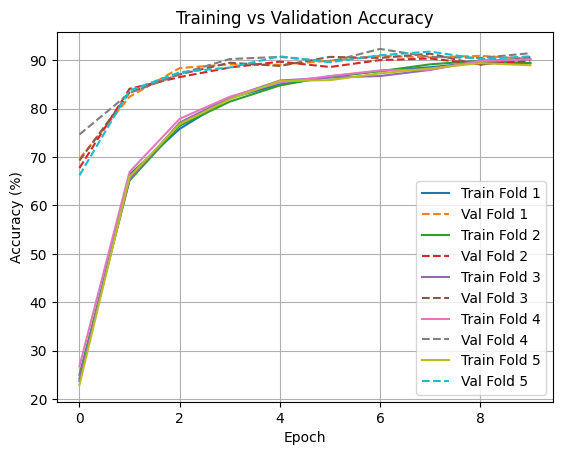

In [9]:
for fold, metrics in fold_metrics.items():
    plt.plot(metrics['train_accuracies'], label=f'Train Fold {fold}')
    plt.plot(metrics['val_accuracies'], label=f'Val Fold {fold}', linestyle='--')

plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

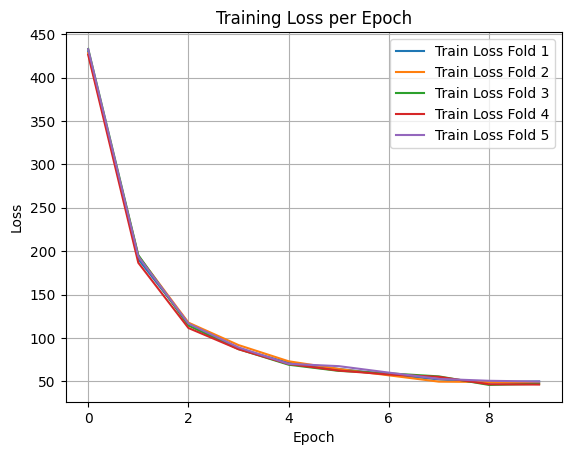

In [10]:
for fold, metrics in fold_metrics.items():
    plt.plot(metrics['train_losses'], label=f'Train Loss Fold {fold}')

plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
best_fold = max(fold_metrics.items(), key=lambda x: max(x[1]['val_accuracies']))[0]
print(f" Best fold (highest val acc): Fold {best_fold}")
print(f" Best val acc: {max(fold_metrics[best_fold]['val_accuracies']):.2f}%")

 Best fold (highest val acc): Fold 4
 Best val acc: 92.32%


Test

In [12]:
# Recreate model architecture
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load("resnet50_fold3.pth", map_location=device))
model.to(device)
model.eval()

test_dataset = AnimalDataset(test_images, test_labels, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing on held-out test set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_targets, all_preds) * 100
print(f"Fold 3 Test Accuracy: {test_accuracy:.2f}%")

Testing on held-out test set: 100%|██████████| 26/26 [00:05<00:00,  4.97it/s]

Fold 3 Test Accuracy: 91.67%


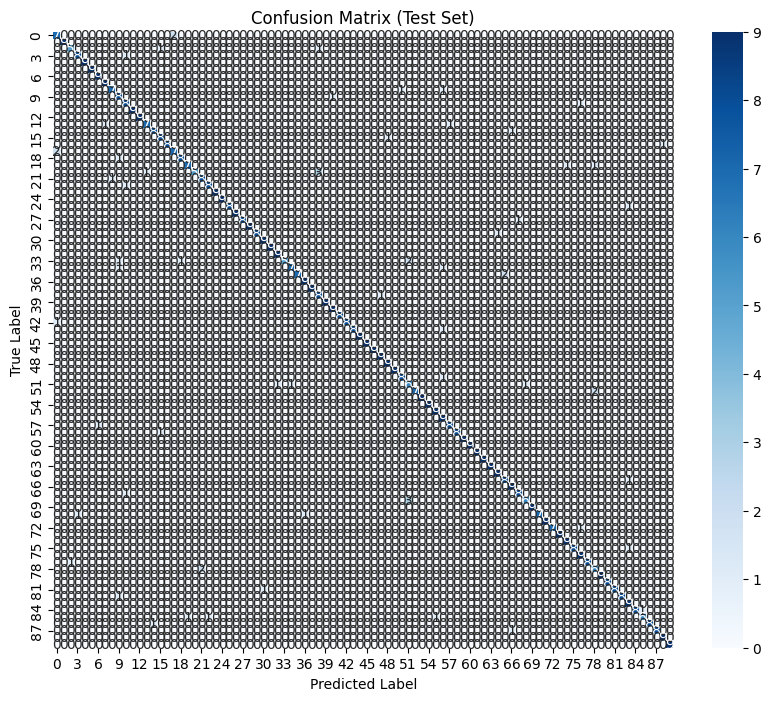

In [13]:
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [14]:
# Get label-to-index mapping from the test_dataset object
idx_to_label = {v: k for k, v in test_dataset.label_to_idx.items()}

# Determine which classes appear in the test set
used_label_indices = np.unique(all_targets)

# Map those class indices to their label names
target_names = [idx_to_label[idx] for idx in used_label_indices]

print("Classification Report (Test Set):")
print(classification_report(all_targets, all_preds, target_names=target_names))

Classification Report (Test Set):
                precision    recall  f1-score   support

      antelope       0.70      0.78      0.74         9
        badger       1.00      1.00      1.00         9
           bat       0.83      0.71      0.77         7
          bear       0.89      0.89      0.89         9
           bee       1.00      1.00      1.00         9
        beetle       1.00      1.00      1.00         9
         bison       0.90      1.00      0.95         9
          boar       0.90      1.00      0.95         9
     butterfly       0.88      0.78      0.82         9
           cat       0.67      0.89      0.76         9
   caterpillar       0.73      0.89      0.80         9
    chimpanzee       1.00      1.00      1.00         9
     cockroach       1.00      1.00      1.00         9
           cow       0.88      0.78      0.82         9
        coyote       0.89      0.89      0.89         9
          crab       0.80      0.89      0.84         9
          cro